# NLP Similarity Approaches

In this notebook i'll show alternative approaches to determine textual similarity. Basic approach from IR is keyword matching (tf/idf), but there is more options that can work as well or better. Combining approaches can give best resuts/

Dataset and competition for search relevance is here: https://www.kaggle.com/c/crowdflower-search-relevance

In [1]:
import pandas as pd

df = pd.read_csv('data/crowdflower-search-relevance.csv', index_col=0)

## Dataset

Let's load the data and have a quick look at the available variables.

In [2]:
df.head()

,query,product_title,product_description,median_relevance,relevance_variance
id,,,,,
1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [3]:
df.shape

(10158, 5)

## Preprocessing 

So from the dataset we saw two columns describing the product (title, description) and one column with a query. We'll combine the two product columns. Also there is some empty values, so we'll fill those up.

In [4]:
df['query'].fillna('', inplace=True)
df['product_title'].fillna('', inplace=True)
df['product_description'].fillna('', inplace=True)

In [5]:
def concatenate_title_and_description(row):
    return row['product_title'] + ' ' + row['product_description']

df['product_title_and_description'] = df.apply(concatenate_title_and_description, axis=1)

## Text cleaning

Next step is cleaning of the texts. The gensim library has nice functions for this, so we'll use those. Basically it will remove punctuation, symbols, stopwords and numbers. This should help determining textual similarity.

In [7]:
from gensim.parsing.preprocessing import preprocess_documents

query_texts = preprocess_documents(df['query'])
product_title_and_description_texts = preprocess_documents(df['product_title_and_description'])

Let's check out a few examples:

In [8]:
query_texts[0]

['bridal', 'shower', 'decor']

In [9]:
query_texts[23]

['girl', 'halloween', 'costum']

## Dictionary & transforming to numbers

Now we have the cleaned texts, so we'll transform them to numbers as gensim library requires that for further processing.

In [10]:
from gensim.corpora import Dictionary

dictionary = Dictionary(query_texts + product_title_and_description_texts)

In [11]:
len(dictionary)

18303

In [12]:
dictionary.filter_extremes(no_below=5, no_above=0.2)

In [13]:
len(dictionary)

5784

In [14]:
query_corpus = [dictionary.doc2bow(x) for x in query_texts]
product_title_and_description_corpus = [dictionary.doc2bow(x) for x in product_title_and_description_texts]

all_corpus = query_corpus + product_title_and_description_corpus

## Process with Tf/Idf and LSI

So now we'll apply two possible similarity models to our data:

- Tf/Idf transformation: This counts word frequencies in documents (query/product) and overall. The logic is that uncommon words that appear multiple times in a product carry a lot of meaning. (This principle is common in all search engines)
- LSI transformation: This is an SVD decomposition on top of tf/idf. It finds co-occurring words and decomposes the texts into co-occurring topics/dimensions. The idea is that each topic/diminsion has a specific semantic meaning.
- Doc2Vec embedding: An embedding technique for words/docs. It analyzes which words occur in the same context and maps them close in a high dimensional space. The idea is that similar context means the words share meaning.

So let's go transform out data!

In [15]:
tfidf_dimensions = len(dictionary)
lsi_dimensions = 150
doc2vec_dimensions = 75

In [16]:
from gensim.models import TfidfModel

tfidf = TfidfModel(all_corpus, id2word=dictionary)

query_tfidf = tfidf[query_corpus]
product_title_and_description_tfidf = tfidf[product_title_and_description_corpus]
all_tfidf = tfidf[all_corpus]

In [17]:
from gensim.models import LsiModel

lsi = LsiModel(all_tfidf, id2word=dictionary)

query_lsi = lsi[query_tfidf]
product_title_and_description_lsi = lsi[product_title_and_description_tfidf]
all_lsi = lsi[all_tfidf]

In [18]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

query_tagged_docs = [TaggedDocument(x, [i]) for i, x in enumerate(query_texts)]
title_and_description_tagged_docs = [TaggedDocument(x, [i]) for i, x in enumerate(product_title_and_description_texts, len(query_texts))]

all_tagged_docs = query_tagged_docs + title_and_description_tagged_docs

d2v_model = Doc2Vec(all_tagged_docs, vector_size=doc2vec_dimensions, epochs=40, workers=4)

Quick intermezzo, what did doc2vec learn? What words are similar to "pillow"? Does it make sense?

In [19]:
d2v_model.wv.most_similar('pillow')

[('bed', 0.57822585105896),
 ('sleep', 0.538665235042572),
 ('sleeper', 0.5267432928085327),
 ('sham', 0.5035320520401001),
 ('surya', 0.49588605761528015),
 ('stomach', 0.48900169134140015),
 ('topper', 0.4878620505332947),
 ('blanket', 0.45482903718948364),
 ('luxuri', 0.44911447167396545),
 ('snore', 0.4265357255935669)]

So now we've trained the models, so let's transform our data.

In [20]:
from gensim.matutils import sparse2full

df['query_tfidf'] = [sparse2full(x, tfidf_dimensions) for x in query_tfidf]
df['product_title_and_description_tfidf'] = [sparse2full(x, tfidf_dimensions) for x in product_title_and_description_tfidf]

df['query_lsi'] = [sparse2full(x, tfidf_dimensions) for x in query_lsi]
df['product_title_and_description_lsi'] = [sparse2full(x, tfidf_dimensions) for x in product_title_and_description_lsi]

df['query_doc2vec'] = [d2v_model.infer_vector(x) for x in query_texts]
df['product_title_and_description_doc2vec'] = [d2v_model.infer_vector(x) for x in product_title_and_description_texts]

## Similarity

We've learned/trained our models and transformed our data. Next step is to determine similarity between product and query, this then could be used in a search engine to sort results!

We'll determine similarity by cosine distance:

In [21]:
from scipy.spatial.distance import cosine

def cosine_distance_tfidf(row):
    return cosine(row['query_tfidf'], row['product_title_and_description_tfidf'])

def cosine_distance_lsi(row):
    return cosine(row['query_lsi'], row['product_title_and_description_lsi'])

def cosine_distance_doc2vec(row):
    return cosine(row['query_doc2vec'], row['product_title_and_description_doc2vec'])

df['distance_tfidf'] = df.apply(cosine_distance_tfidf, axis=1)
df['distance_lsi'] = df.apply(cosine_distance_lsi, axis=1)
df['distance_doc2vec'] = df.apply(cosine_distance_doc2vec, axis=1)

/home/dehling/Documents/machine-learnings/lib/python3.5/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Lets look at some examples to see which products would match a query with our approach:

In [25]:
df[['query', 'product_title', 'median_relevance', 'distance_tfidf']].sort_values(by=['query', 'distance_tfidf']).head(n=10)

,query,product_title,median_relevance,distance_tfidf
id,,,,
14692,16 gb memory card,Cisco - flash memory card - 16 GB - SD,4,0.377292
23279,16 gb memory card,EP Memory - flash memory card - 16 GB - Compac...,4,0.392852
4058,16 gb memory card,Samsung EVO MB-SP16D/AM 16GB Class 10 SD Memor...,4,0.399038
17873,16 gb memory card,Samsung 16gb Micro SDHC Class 2 Memory Card wi...,4,0.411266
9497,16 gb memory card,Lexar 600x 16GB MicroSDHC Memory Card with USB...,4,0.417127
20526,16 gb memory card,SanDisk 16GB microSDHC Memory Card - Black (SD...,4,0.442482
19846,16 gb memory card,Dane 16GB microSD Memory Card with Adapter - B...,4,0.445012
18757,16 gb memory card,16GB MicroSD Memory Card with SD Adapter (Pack...,4,0.449338
24971,16 gb memory card,SanDisk Ultra 16GB microSDHC Memory Card,4,0.463154


Looks pretty sensible, right? For a query about a memory card various memory cards are suggested. I'm happy!

In [26]:
df[['query', 'product_title', 'median_relevance', 'distance_lsi']].sort_values(by=['query', 'distance_lsi']).head(n=10)

,query,product_title,median_relevance,distance_lsi
id,,,,
19182,16 gb memory card,Transcend 16GB MicroSD Class 4 Flash Memory Card,4,0.007564
32384,16 gb memory card,Transcend 16gb Class 10 SDHC Flash Memory Card,4,0.010354
23279,16 gb memory card,EP Memory - flash memory card - 16 GB - Compac...,4,0.012274
29717,16 gb memory card,Kingston 4GB 8GB 16GB 32GB Class 4 microSD SDH...,4,0.016376
20967,16 gb memory card,SanDisk Ultra 16G 32GB 64GB 128GB 40MB/S SD SD...,4,0.024250
14692,16 gb memory card,Cisco - flash memory card - 16 GB - SD,4,0.028702
13919,16 gb memory card,SanDisk - flash memory card - 16 GB - microSDHC,4,0.041562
19317,16 gb memory card,SanDisk 16GB Class 4 microSDHC Memory Card,4,0.042414
23804,16 gb memory card,SanDisk Ultra 16GB UHI-I Class 10 Micro SDHC M...,4,0.054703


LSI also looks sensible, similar products are suggested.

## Evaluation

Let's compare the similarity we calculated against the human assessed relevance. For this we'll use correlation.

In [20]:
df['median_relevance'].corr(df['distance_tfidf'])

-0.364037545605384

In [21]:
df['median_relevance'].corr(df['distance_lsi'])

-0.3669726247025937

In [72]:
df['median_relevance'].corr(df['distance_doc2vec'])

-0.08686668817840917

Let's also make some plots to visualize the relation between calculated similarity and assessed relevance.

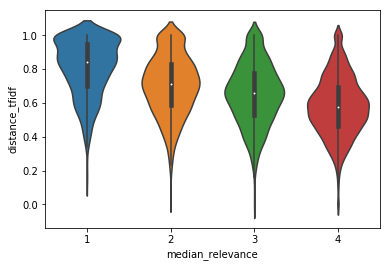

In [22]:
import seaborn as sns
%matplotlib inline

sns.violinplot(x='median_relevance', y='distance_tfidf', data=df)

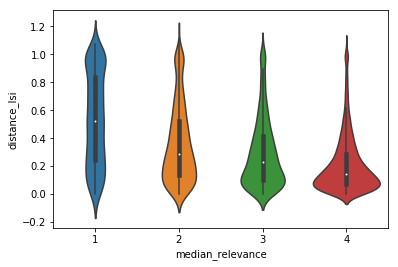

In [23]:
sns.violinplot(x='median_relevance', y='distance_lsi', data=df)

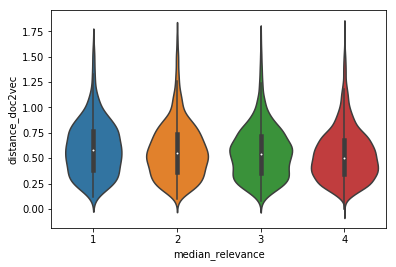

In [34]:
sns.violinplot(x='median_relevance', y='distance_doc2vec', data=df)

Each of the similarity approaches shows different results, and perform differently good/bad.

* TF/IDF and LSI do quite well on correlation and find relevant product for a query
* Doc2Vec doesn't do well, probably it needs better training data or more finetuning. With more energy spent it might work, but not out-of-the-box at least.

I hope you enjoyed!